샘플 수: 1


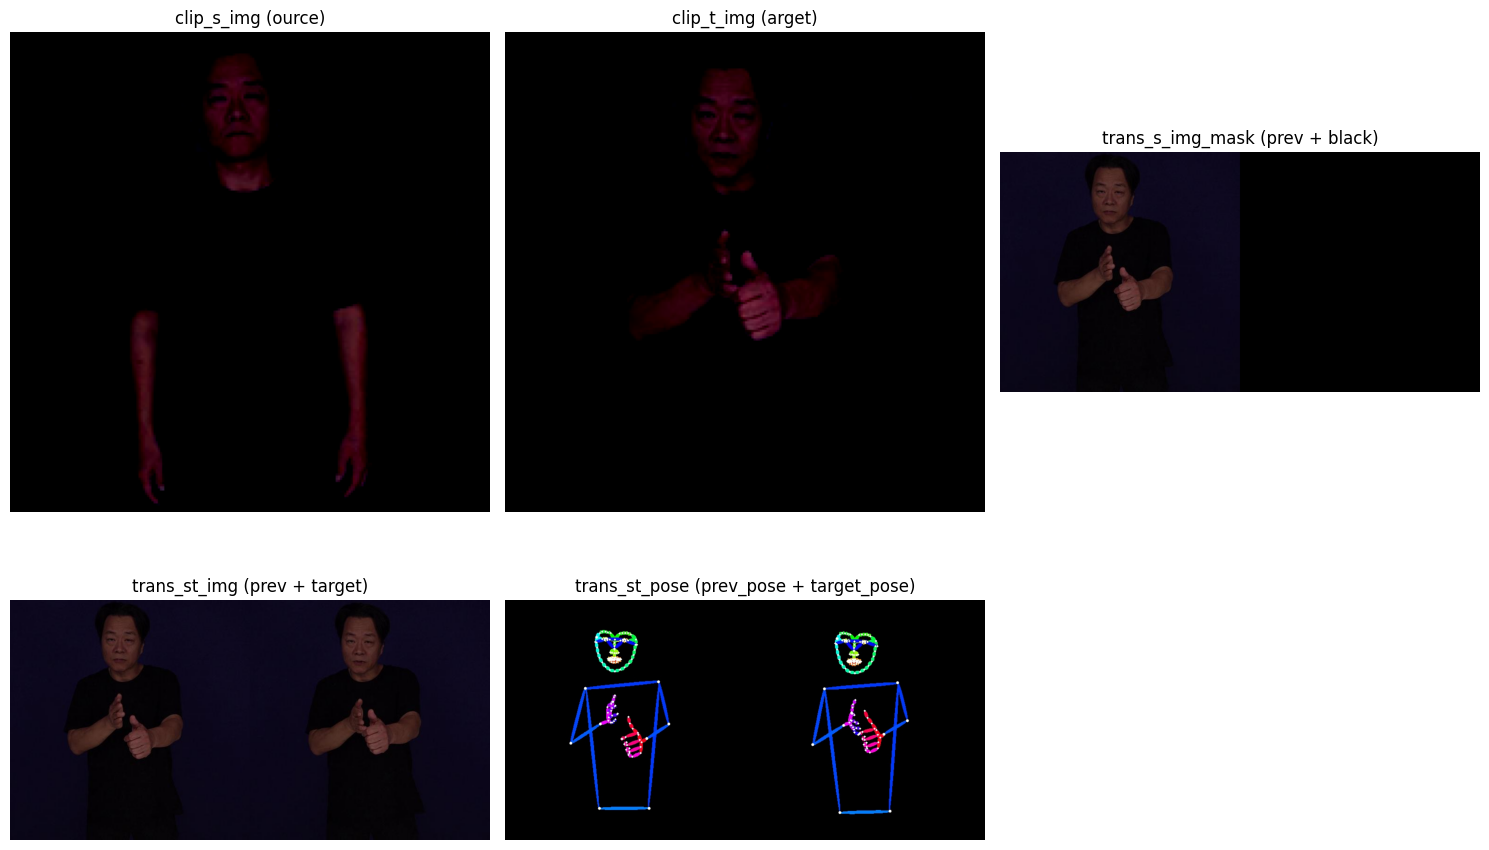

In [2]:
import os
import json
import random
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from transformers import CLIPImageProcessor

# 시각화 함수
def show_tensor_image(tensor, title=""):
    tensor = tensor.clone().detach().cpu()
    tensor = (tensor * 0.5 + 0.5).clamp(0, 1)
    img = TF.to_pil_image(tensor)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")


# 데이터셋 정의
class InpaintDataset(Dataset):
    def __init__(self, json_file, image_root_path, size=(512, 512), imgp_drop_rate=0.0, imgg_drop_rate=0.0):
        self.data = json.load(open(json_file)) if isinstance(json_file, str) else json_file
        print("샘플 수:", len(self.data))
        self.image_root_path = image_root_path
        self.size = size
        self.imgp_drop_rate = imgp_drop_rate
        self.imgg_drop_rate = imgg_drop_rate
        self.clip_image_processor = CLIPImageProcessor()

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

    def __getitem__(self, idx):
        item = self.data[idx]
        s_img_path = os.path.join(self.image_root_path, item["source_image"])
        p_img_path = os.path.join(self.image_root_path, item["prev_image"])
        t_img_path = os.path.join(self.image_root_path, item["target_image"])

        s_img = Image.open(s_img_path).convert("RGB").resize(self.size, Image.BICUBIC)
        p_img = Image.open(p_img_path).convert("RGB").resize(self.size, Image.BICUBIC)
        t_img = Image.open(t_img_path).convert("RGB").resize(self.size, Image.BICUBIC)

        black_img = Image.new("RGB", self.size, (0, 0, 0))
        s_img_mask = Image.new("RGB", (self.size[0] * 2, self.size[1]))
        s_img_mask.paste(p_img, (0, 0))
        s_img_mask.paste(black_img, (self.size[0], 0))

        st_img = Image.new("RGB", (self.size[0] * 2, self.size[1]))
        st_img.paste(p_img, (0, 0))
        st_img.paste(t_img, (self.size[0], 0))

        s_pose = Image.open(p_img_path.replace("/img/", "/pose_img/").replace(".jpg", "_pose.jpg")).convert("RGB").resize(self.size, Image.BICUBIC)
        t_pose = Image.open(t_img_path.replace("/img/", "/pose_img/").replace(".jpg", "_pose.jpg")).convert("RGB").resize(self.size, Image.BICUBIC)

        st_pose = Image.new("RGB", (self.size[0] * 2, self.size[1]))
        st_pose.paste(s_pose, (0, 0))
        st_pose.paste(t_pose, (self.size[0], 0))

        trans_s_img_mask = self.transform(s_img_mask)
        trans_st_img = self.transform(st_img)
        trans_st_pose = self.transform(st_pose)

        clip_s_img = self.clip_image_processor(images=s_img, return_tensors="pt").pixel_values.squeeze(0)
        clip_t_img = self.clip_image_processor(images=t_img, return_tensors="pt").pixel_values.squeeze(0)

        if random.random() < self.imgp_drop_rate:
            clip_s_img = torch.zeros_like(clip_s_img)
        if random.random() < self.imgg_drop_rate:
            clip_t_img = torch.zeros_like(clip_t_img)

        return {
            "clip_s_img": clip_s_img,
            "clip_t_img": clip_t_img,
            "trans_st_img": trans_st_img,
            "trans_st_pose": trans_st_pose,
            "trans_s_img_mask": trans_s_img_mask,
        }

    def __len__(self):
        return len(self.data)


# ★★★ 여기에 경로만 바꿔주면 바로 실행 가능 ★★★
json_path = "/home/minju/PCDMs/data/check.json"
image_root = "/home/minju/PCDMs/all_test"

# 실행
dataset = InpaintDataset(json_file=json_path, image_root_path=image_root)
sample = dataset[0]

# 시각화
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
show_tensor_image(sample["clip_s_img"], "clip_s_img (ource)")

plt.subplot(2, 3, 2)
show_tensor_image(sample["clip_t_img"], "clip_t_img (arget)")

plt.subplot(2, 3, 3)
show_tensor_image(sample["trans_s_img_mask"], "trans_s_img_mask (prev + black)")

plt.subplot(2, 3, 4)
show_tensor_image(sample["trans_st_img"], "trans_st_img (prev + target)")

plt.subplot(2, 3, 5)
show_tensor_image(sample["trans_st_pose"], "trans_st_pose (prev_pose + target_pose)")

plt.tight_layout()
plt.show()
